In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from neo import io
import pandas as pd
from hmmlearn import hmm

# Load data

In [40]:
r = io.IgorIO(filename='upShots_3623.ibw')
data_an_up = r.read_analogsignal()
data_arr_up = np.array(data_an_up)

r = io.IgorIO(filename='downShots_3624.ibw')
data_an_down = r.read_analogsignal()
data_arr_down = np.array(data_an_down)
data_arr_up.shape

(9992, 5000)

# Algorithm

In [4]:
test_data_raw = np.round(np.array(data_arr_up[:,2400])[15:2500], 3)
test_data = (test_data_raw - np.ones(len(test_data_raw))*-0.20)/(np.ones(len(test_data_raw))*0.001)
test_data = (np.rint(test_data)).astype(int)

In [5]:
# Up case

test_data_counts = np.zeros(750)

for i in range(len(test_data)):
    test_data_counts[test_data[i]] += 1
    

b_est_1 = test_data_counts/(np.ones(len(test_data_counts))*len(test_data))

In [6]:
test_data_raw_2 = np.round(np.array(data_arr_up[:,2401])[15:2500], 3)
test_data_2 = (test_data_raw_2 - np.ones(len(test_data_raw))*-0.20)/(np.ones(len(test_data_raw))*0.001)
test_data_2 = (np.rint(test_data_2)).astype(int)

In [7]:
test_data_counts_2 = np.zeros(750)

for i in range(len(test_data_2)):
    test_data_counts[test_data_2[i]] += 1
    

b_est_2 = test_data_counts_2/(np.ones(len(test_data_counts_2))*len(test_data))

In [12]:
A = np.array([1])
pi = np.array([1])

p_1 = forward(test_data_2, A, b_est_1, pi)
p_2 = forward(test_data_2, A, b_est_2, pi)

# Test model (test)

In [10]:
def viterbi(y, A, B, Pi=None):
    """
    Return the MAP estimate of state trajectory of Hidden Markov Model.

    Parameters
    ----------
    y : array (T,)
        Observation state sequence. int dtype.
    A : array (K, K)
        State transition matrix. See HiddenMarkovModel.state_transition  for
        details.
    B : array (K, M)
        Emission matrix. See HiddenMarkovModel.emission for details.
    Pi: optional, (K,)
        Initial state probabilities: Pi[i] is the probability x[0] == i. If
        None, uniform initial distribution is assumed (Pi[:] == 1/K).

    Returns
    -------
    x : array (T,)
        Maximum a posteriori probability estimate of hidden state trajectory,
        conditioned on observation sequence y under the model parameters A, B,
        Pi.
    T1: array (K, T)
        the probability of the most likely path so far
    T2: array (K, T)
        the x_j-1 of the most likely path so far
    """
    # Cardinality of the state space
    K = A.shape[0]
    # Initialize the priors with default (uniform dist) if not given by caller
    Pi = Pi if Pi is not None else np.full(K, 1 / K)
    T = len(y)
    T1 = np.empty((K, T), 'd')
    T2 = np.empty((K, T), 'B')

    # Initilaize the tracking tables from first observation
    T1[:, 0] = Pi * B[:, y[0]]
    T2[:, 0] = 0

    # Iterate throught the observations updating the tracking tables
    for i in range(1, T):
        T1[:, i] = np.max(T1[:, i - 1] * A.T * B[np.newaxis, :, y[i]].T, 1)
        T2[:, i] = np.argmax(T1[:, i - 1] * A.T, 1)

    # Build the output, optimal model trajectory
    x = np.empty(T, 'B')
    x[-1] = np.argmax(T1[:, T - 1])
    for i in reversed(range(1, T)):
        x[i - 1] = T2[x[i], i]

    return x, T1, T2

In [11]:
def forward(V, a, b, initial_distribution):
    
    # creates empty matrix of dimensions (length of time sequence TIMES nr of states)
    alpha = np.zeros((V.shape[0], a.shape[0]))
    #print('forward 1',alpha)
    
    
    # populates the first row (time step) with (initial probability * probability of observing a variable given some state) for each state
    alpha[0, :] = initial_distribution * b[int(V[0])]
    #print('forward 2', b[:, int(V[0])])
 
    # iterates over time
    for t in range(1, V.shape[0]):
        # iterates over the N states
        for j in range(a.shape[0]):
            # Matrix Computation Steps
            #                  ((1x2) . (1x2))      *     (1)
            #                        (1)            *     (1)
            alpha[t, j] = alpha[t - 1].dot(a[j]) * b[int(V[t])]
    
    return alpha # returns a matrix alpha indexed as [t, j] with t from 0 to T and j from 1 to N

# Train model (small)

In [13]:
train_up_set_processed = []

for i in range(2500):
    temp_data_raw = np.round(np.array(data_arr_up[:,i])[15:2500], 2)
    temp_data = (temp_data_raw - np.ones(len(temp_data_raw))*-0.20)/(np.ones(len(temp_data_raw))*0.01)
    temp_data = (np.rint(temp_data)).astype(int)
    
    temp_data_counts = np.zeros(75)
    for j in range(len(temp_data)):
        temp_data_counts[temp_data[j]] += 1
        
    temp_b_est = temp_data_counts/(np.ones(len(temp_data_counts))*len(temp_data))
    
    train_up_set_processed.append(temp_b_est)

In [17]:
trained_b_up = np.average(np.array(train_up_set_processed), axis = 0)

In [18]:
train_down_set_processed = []

for i in range(2500):
    temp_data_raw = np.round(np.array(data_arr_down[:,i])[15:2500], 2)
    temp_data = (temp_data_raw - np.ones(len(temp_data_raw))*-0.20)/(np.ones(len(temp_data_raw))*0.01)
    temp_data = (np.rint(temp_data)).astype(int)
    
    temp_data_counts = np.zeros(75)
    for j in range(len(temp_data)):
        temp_data_counts[temp_data[j]] += 1
        
    temp_b_est = temp_data_counts/(np.ones(len(temp_data_counts))*len(temp_data))
    
    train_down_set_processed.append(temp_b_est)

In [19]:
trained_b_down = np.average(np.array(train_down_set_processed), axis = 0)

In [20]:
B = np.array([trained_b_up, trained_b_down])
A = np.array([[1,0],[0,1]])
pi = np.array([0.5, 0.5])

# Test model (small)

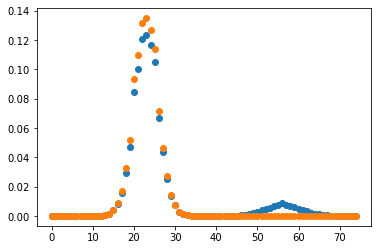

In [21]:
plt.scatter(range(len(trained_b_up)), trained_b_up)
plt.scatter(range(len(trained_b_down)), trained_b_down)
#plt.ylim(0,0.02)

In [88]:
test_data_up_raw = np.round(np.array(data_arr_up[:,3379])[15:2300], 2)
test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
test_data_up = (np.rint(test_data_up)).astype(int)
test_data_counts_up = np.zeros(75)
for j in range(len(test_data_up)):
    test_data_counts_up[test_data_up[j]] += 1
prob_dist_up = test_data_counts_up/(np.ones(len(test_data_counts_up))*len(test_data_counts_up))

test_data_down_raw = np.round(np.array(data_arr_down[:,4393])[15:2300], 2)
test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
test_data_down = (np.rint(test_data_down)).astype(int)
test_data_counts_down = np.zeros(75)
for j in range(len(test_data_down)):
    test_data_counts_down[test_data_down[j]] += 1
prob_dist_down = test_data_counts_down/(np.ones(len(test_data_counts_down))*len(test_data_counts_down))

In [73]:
print(test_data_counts_down)
print(test_data_counts_up)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
   2.   9.  24.  37.  69. 122. 211. 258. 314. 316. 292. 230. 168. 101.
  59.  40.  20.  10.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   2.
   5.  14.  29.  44.  96. 137. 264. 281. 281. 306. 289. 195. 154.  95.
  40.  30.   9.   2.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   0.   0.   0.   1.   1.   0.   2.   0.   0.   0.
   1.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]


(0.0, 75.0)

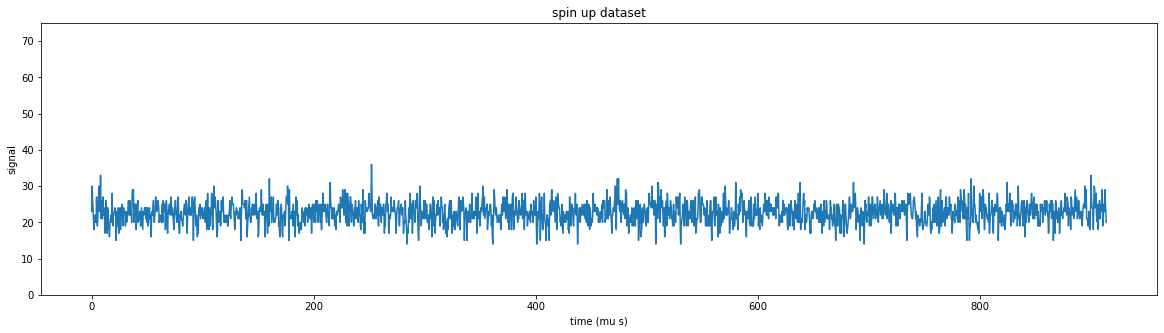

In [78]:
plt.figure(figsize=(20,5))
time_arr = np.array(range(len(test_data_up)))*1e6/(2.5e6)
plt.plot(time_arr,test_data_up)
plt.ylabel('signal')
plt.xlabel('time (mu s)')
plt.title('spin up dataset')
plt.ylim(0,75)

(0.0, 75.0)

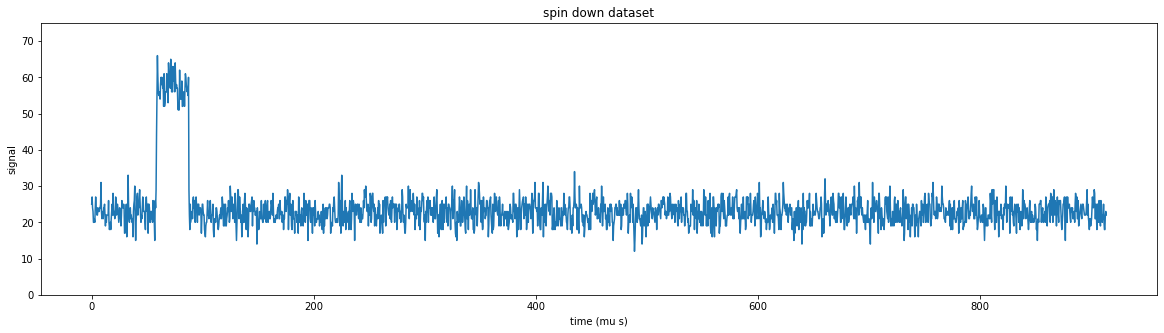

In [89]:
plt.figure(figsize=(20,5))
time_arr = np.array(range(len(test_data_down)))*1e6/(2.5e6)
plt.plot(time_arr,test_data_down)
plt.ylabel('signal')
plt.xlabel('time (mu s)')
plt.title('spin down dataset')
plt.ylim(0,75)

In [120]:
(np.array(range(900-15))*1e6/(2.5e6))[-1]

353.6

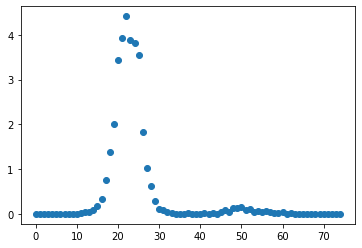

In [30]:
plt.scatter(range(len(prob_dist_up)),prob_dist_up)

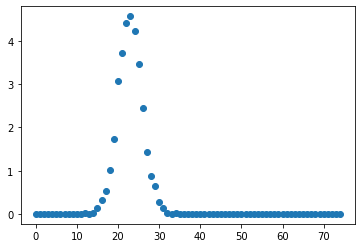

In [31]:
plt.scatter(range(len(prob_dist_down)), prob_dist_down)

In [32]:
model = hmm.CategoricalHMM(n_components=2)
model.transmat_ = A
model.emissionprob_ = B
model.startprob_ = np.array([0.5, 0.5])

In [34]:
model.predict(test_data_down.reshape(1,-1))

array([1, 1, 1, ..., 1, 1, 1])

# Benchmarking 1

In [79]:
model = hmm.CategoricalHMM(n_components=2)
model.transmat_ = A
model.emissionprob_ = B
model.startprob_ = np.array([0.5, 0.5])

total = (4999-2600)*2

corru = 0
wrongu = 0

corrd = 0
wrongd = 0

wrong_ind_up = []
wrong_ind_down = []

for i in range(2600, 5000-1):
    test_data_up_raw = np.round(np.array(data_arr_up[:,i])[15:1691], 2)
    test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
    test_data_up = (np.rint(test_data_up)).astype(int)

    test_data_down_raw = np.round(np.array(data_arr_down[:,i])[15:1691], 2)
    test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
    test_data_down = (np.rint(test_data_down)).astype(int)
    
    res_up_temp = model.predict(test_data_up.reshape(1,-1))
    res_down_temp = model.predict(test_data_down.reshape(1,-1))
    
    if res_up_temp[-1] == 0:
        corru += 1
    else:
        wrongu += 1
        wrong_ind_up.append(i)
        
    if res_down_temp[-1] == 1:
        corrd += 1
    else:
        wrongd += 1
        wrong_ind_down.append(i)

In [81]:
(corrd)/(total/2)

0.9979157982492706

In [90]:
corru/(total/2)

0.8770320967069613

In [83]:
wrong_ind_down

[2648, 3389, 4393, 4414, 4415]

/var/folders/zx/flxs9k9j3q1fr05sp0xh1kj40000gn/T/ipykernel_62623/2900628164.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,5))


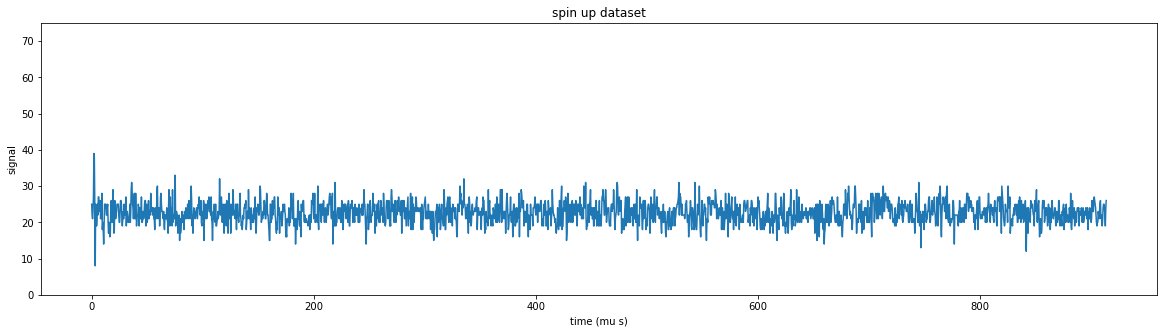

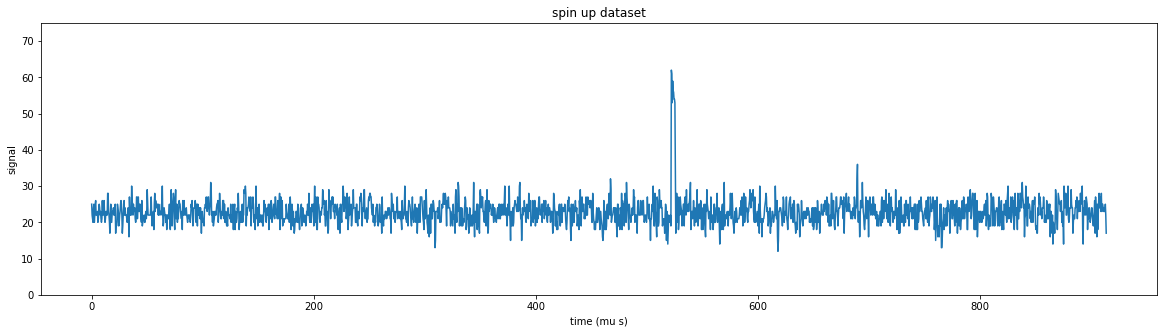

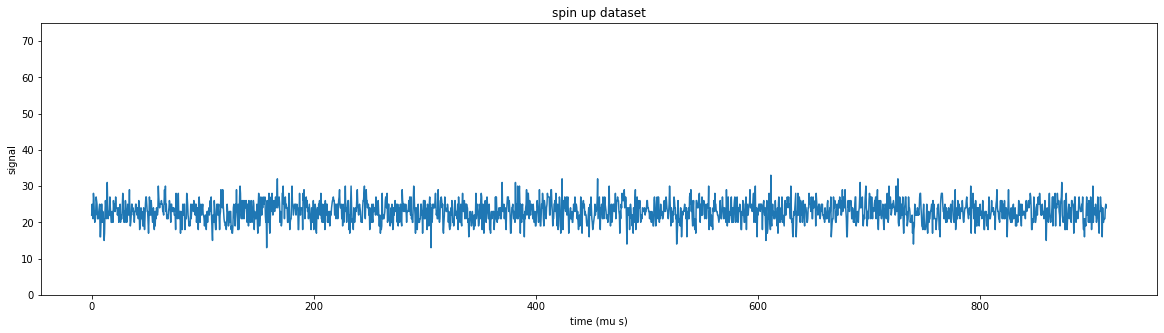

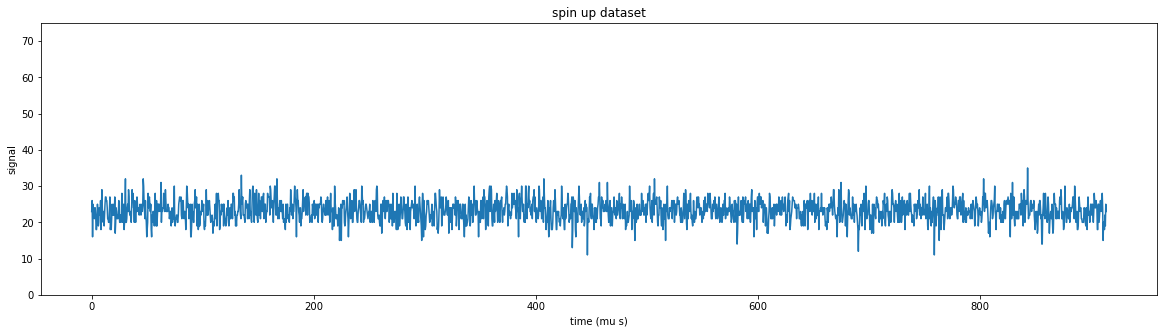

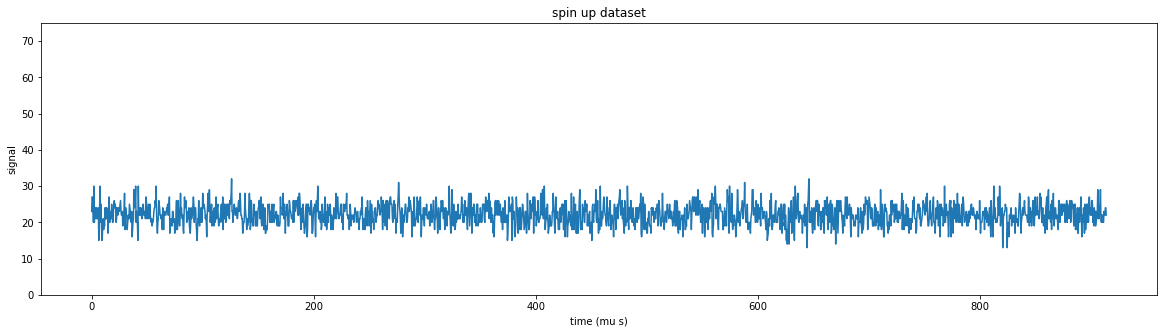

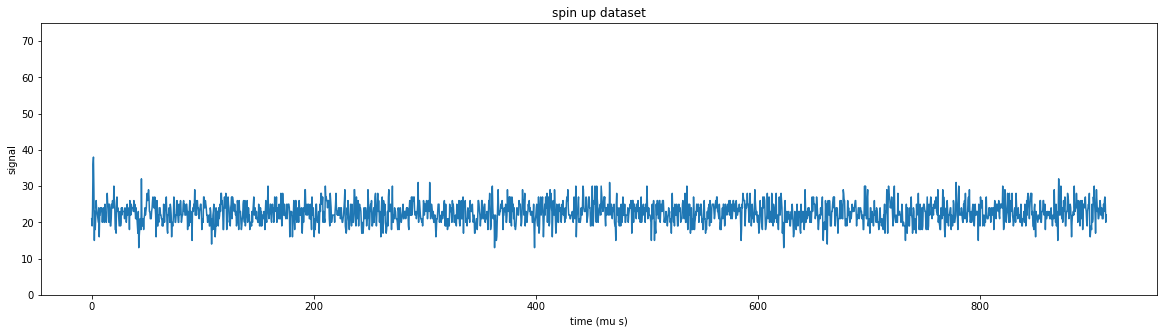

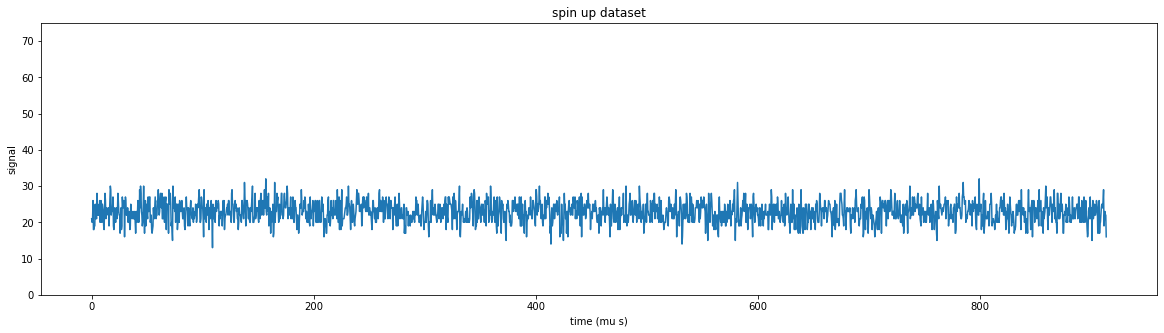

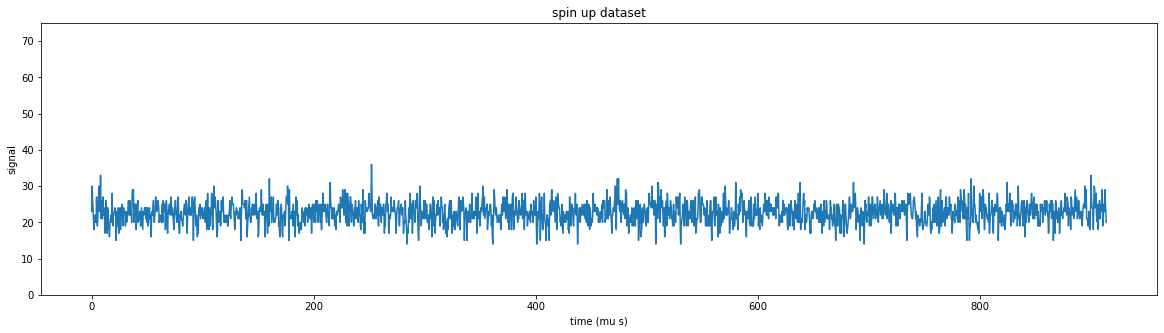

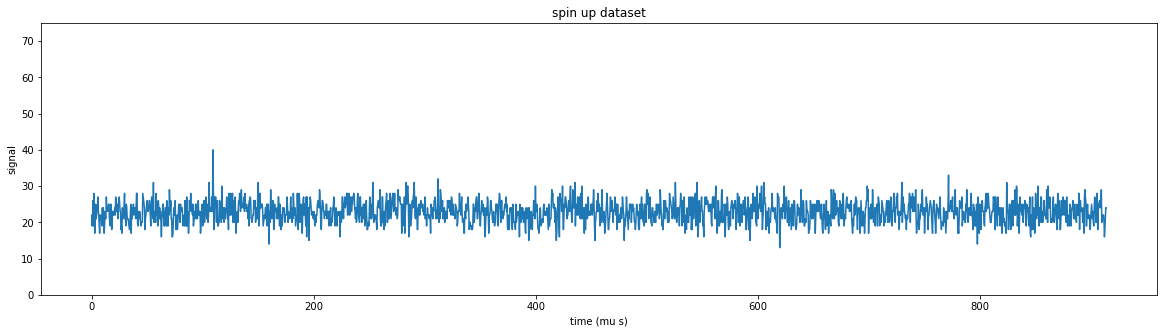

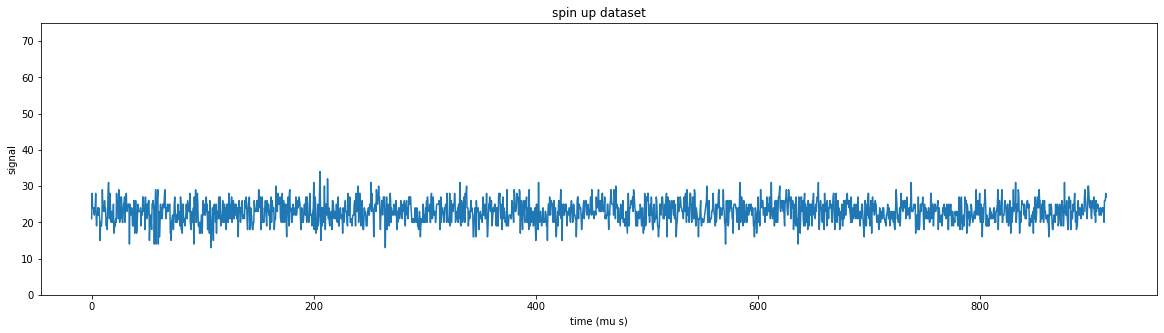

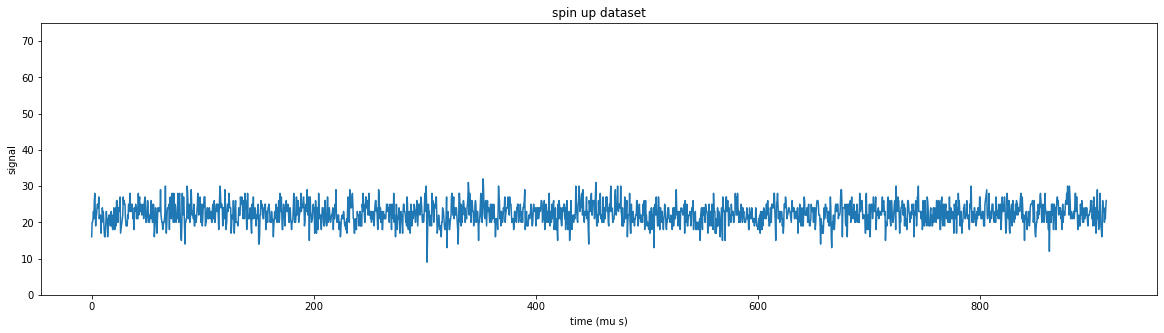

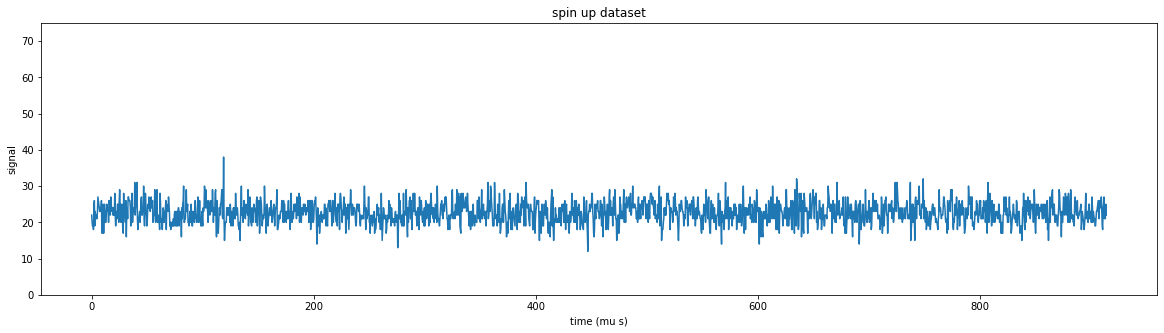

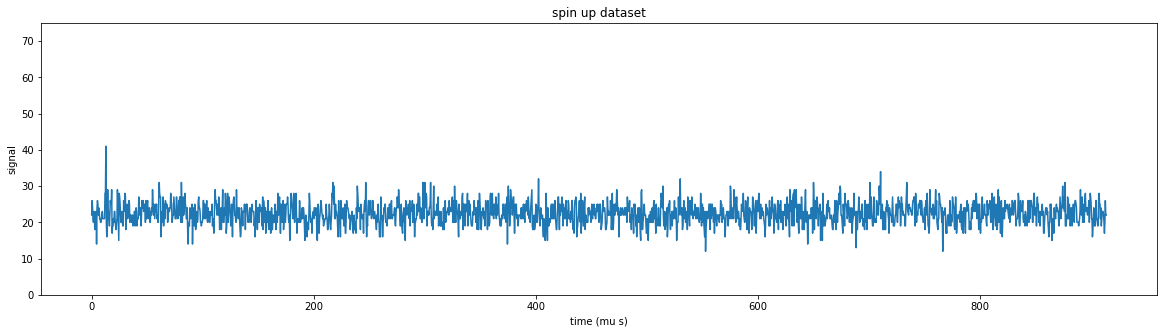

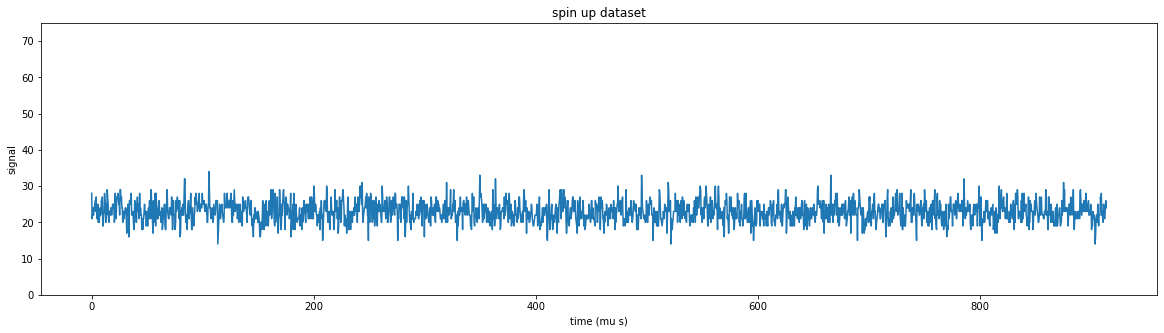

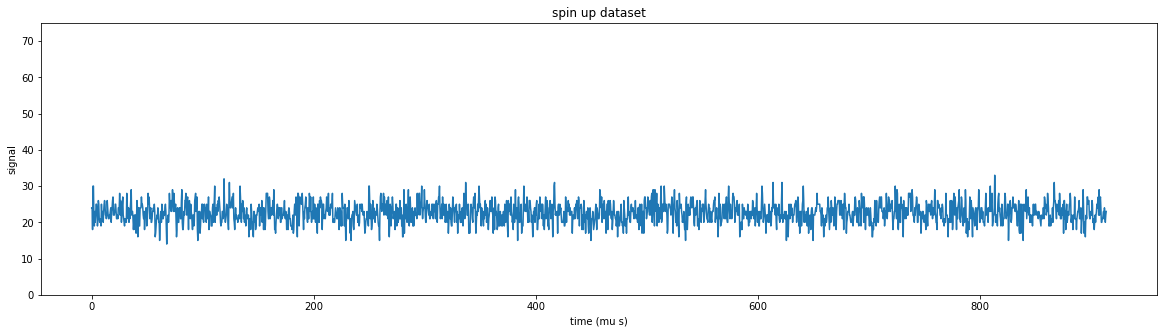

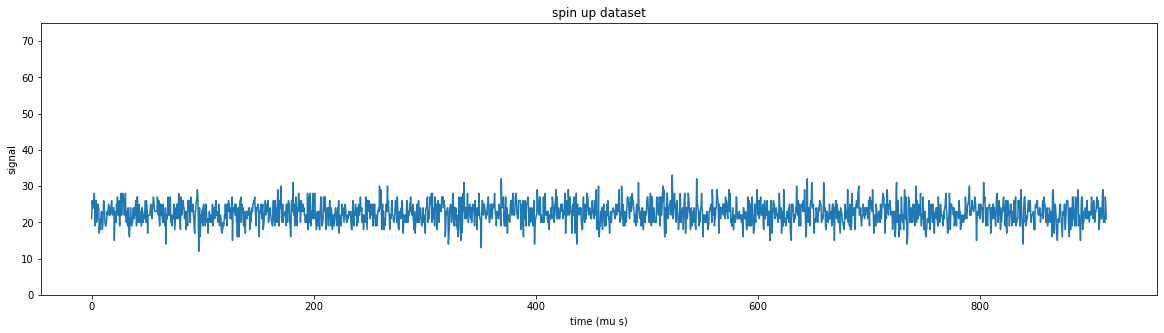

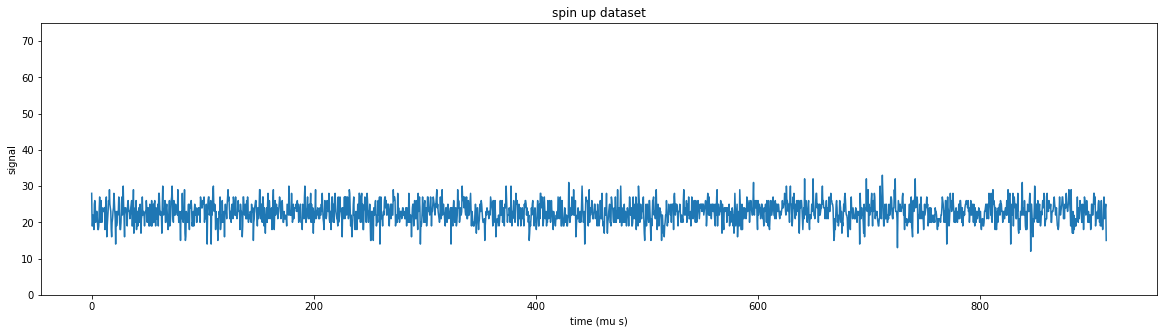

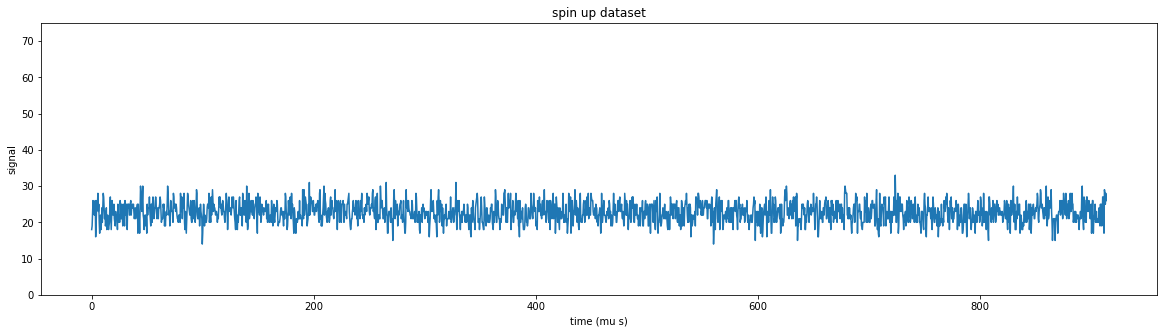

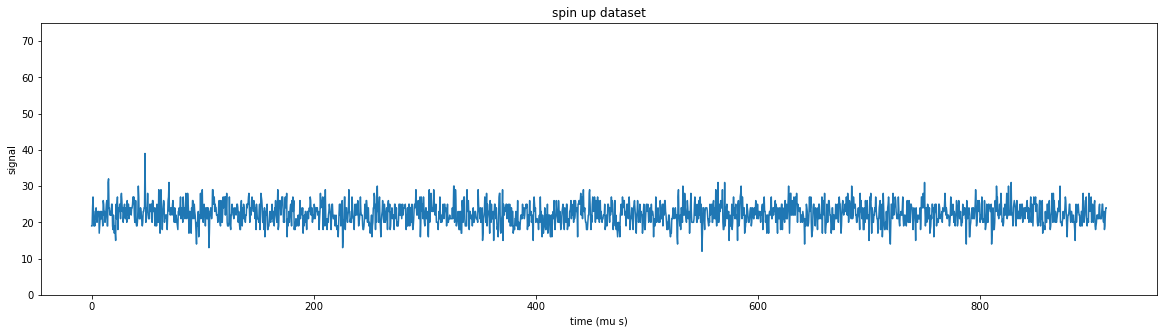

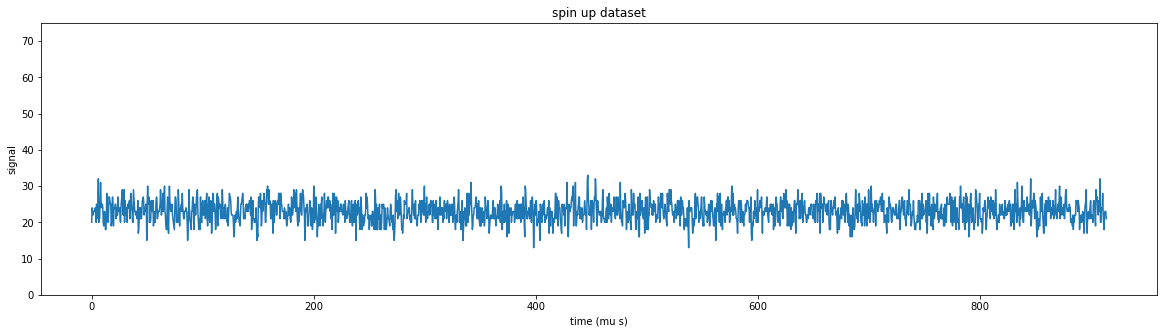

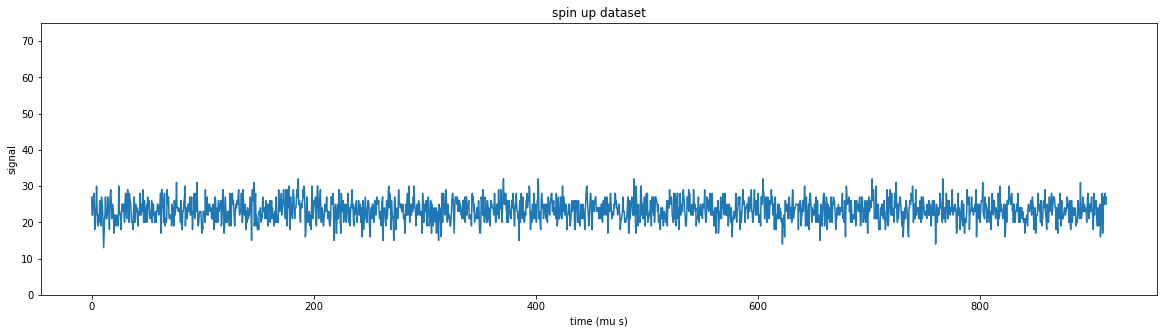

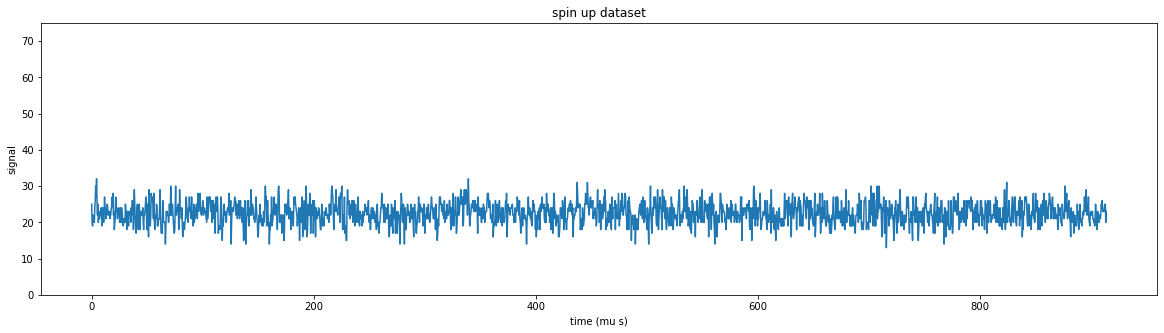

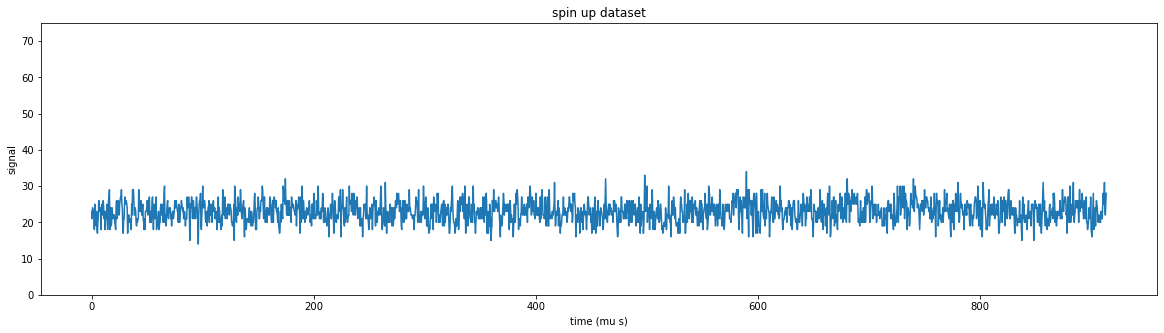

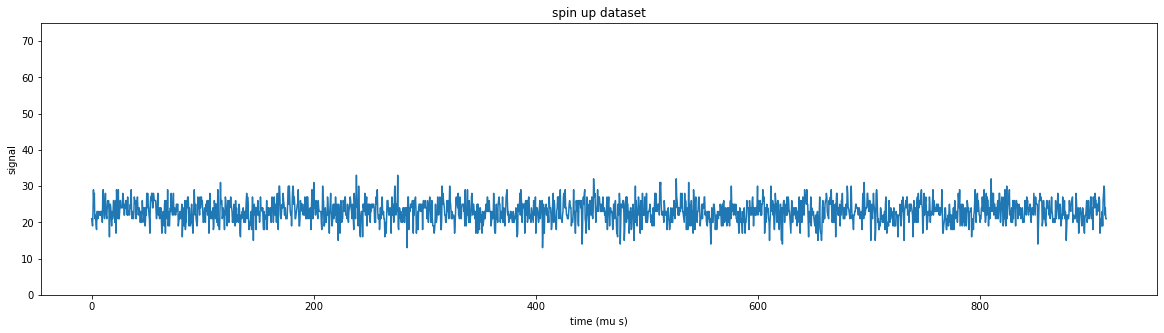

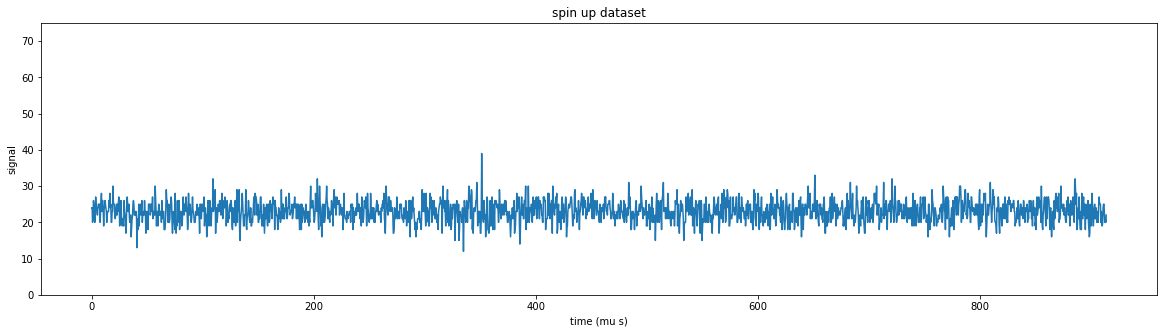

In [155]:
for i in wrong_ind_up:
    test_data_up_raw = np.round(np.array(data_arr_up[:,i])[15:2300], 2)
    test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
    test_data_up = (np.rint(test_data_up)).astype(int)
    test_data_counts_up = np.zeros(75)
    plt.figure(figsize=(20,5))
    time_arr = np.array(range(len(test_data_up)))*1e6/(2.5e6)
    plt.plot(time_arr,test_data_up)
    plt.ylabel('signal')
    plt.xlabel('time (mu s)')
    plt.title('spin up dataset')
    plt.ylim(0,75)


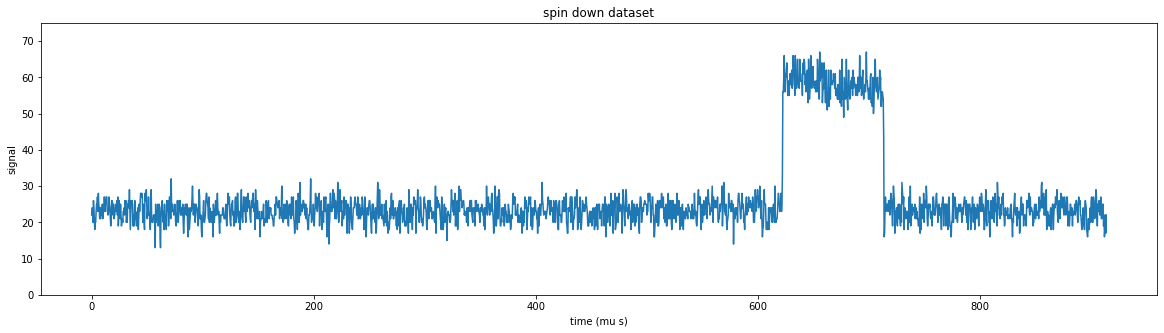

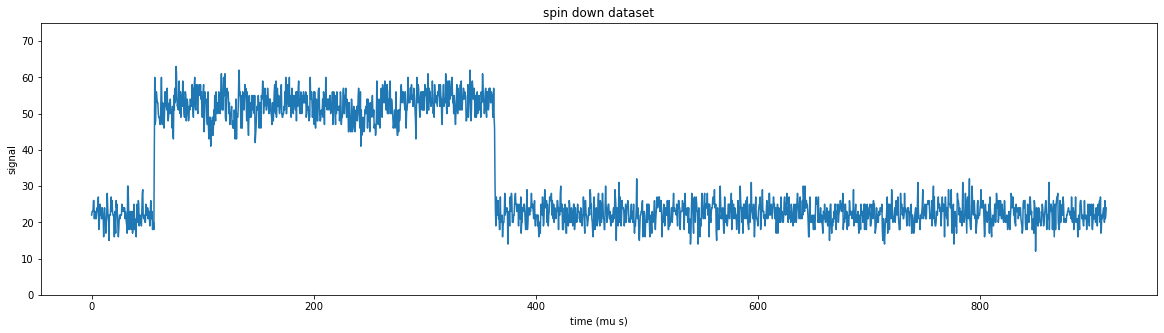

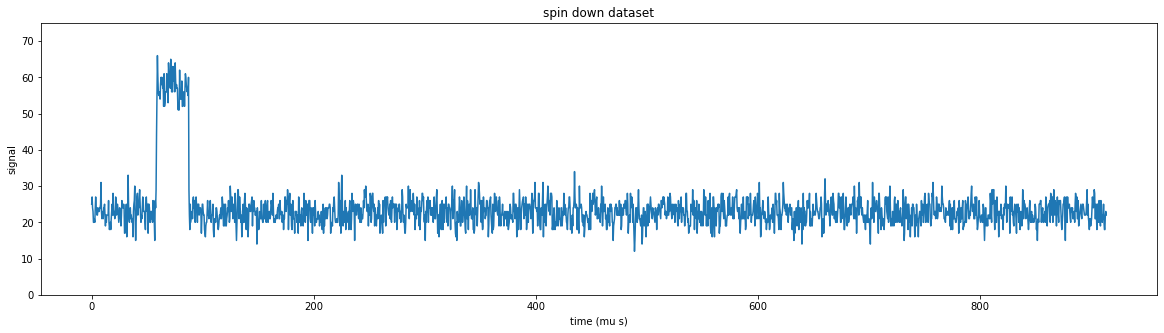

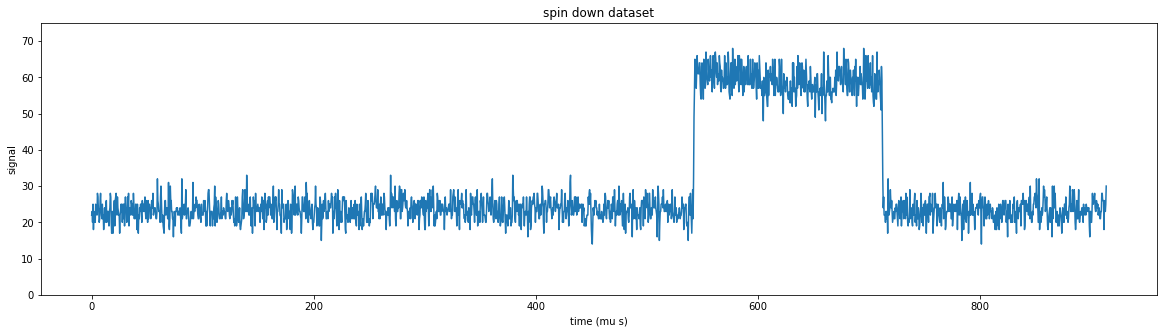

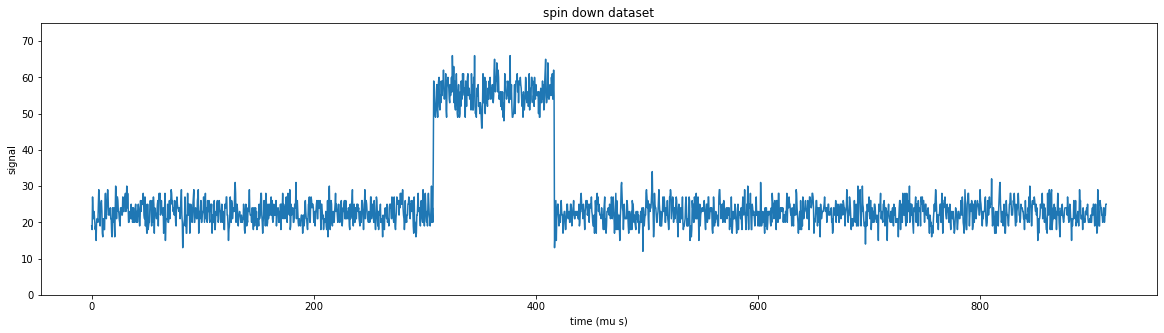

In [150]:
for i in wrong_ind_down:
    test_data_down_raw = np.round(np.array(data_arr_down[:,i])[15:2300], 2)
    test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
    test_data_down = (np.rint(test_data_down)).astype(int)
    plt.figure(figsize=(20,5))
    time_arr = np.array(range(len(test_data_down)))*1e6/(2.5e6)
    plt.plot(time_arr,test_data_down)
    plt.ylabel('signal')
    plt.xlabel('time (mu s)')
    plt.title('spin down dataset')
    plt.ylim(0,75)

# Benchmarking 2

In [152]:
model = hmm.CategoricalHMM(n_components=2)
model.transmat_ = A
model.emissionprob_ = B
model.startprob_ = np.array([0.5, 0.5])

total = (4999-2600)*2

corru = 0
wrongu = 0

corrd = 0
wrongd = 0

wrong_ind_up = []
wrong_ind_down = []

for i in range(2600, 5000-1):
    test_data_up_raw = np.round(np.array(data_arr_up[:,i])[15:1691], 2)
    test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
    test_data_up = (np.rint(test_data_up)).astype(int)

    test_data_down_raw = np.round(np.array(data_arr_down[:,i])[15:1691], 2)
    test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
    test_data_down = (np.rint(test_data_down)).astype(int)
    
    res_up_temp = model.predict(test_data_up.reshape(1,-1))
    res_down_temp = model.predict(test_data_down.reshape(1,-1))
    
    # 2nd check
    temp_up = test_data_up[0:1115]
    temp_down = test_data_down[0:1115]
    if max(temp_up) > 47:
        res_up_temp = [0]
    if max(temp_down) > 47:
        res_down_temp = [0]
    
    if res_up_temp[-1] == 0:
        corru += 1
    else:
        wrongu += 1
        wrong_ind_up.append(i)
        
    if res_down_temp[-1] == 1:
        corrd += 1
    else:
        wrongd += 1
        wrong_ind_down.append(i)

In [167]:
round(corru/(total/2), 4)

0.9896

In [168]:
round((corrd)/(total/2), 4)

0.9979

In [169]:
(0.9979 + 0.9896)/2

0.99375

In [149]:
wrong_ind_down

[2648, 3389, 4393, 4414, 4415]

In [170]:
# Compare to prev method


corru_p = 0
wrongu_p = 0

corrd_p = 0
wrongd_p = 0

p_wrong_ind_u = []
p_wrong_ind_d = []

for i in range(2600, 5000-1):
    test_data_up_raw = np.round(np.array(data_arr_up[:,i])[15:1691], 2)
    test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
    test_data_up = (np.rint(test_data_up)).astype(int)

    test_data_down_raw = np.round(np.array(data_arr_down[:,i])[15:1691], 2)
    test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
    test_data_down = (np.rint(test_data_down)).astype(int)
    

    
    if max(test_data_up) > 47:
        res_up_temp = 0
    else:
        res_up_temp = 1
        
    if max(test_data_down) > 47:
        res_down_temp = 0
    else:
        res_down_temp = 1
    
    if res_up_temp == 0:
        corru_p += 1
    else:
        wrongu_p += 1
        p_wrong_ind_u.append(i)
        
    if res_down_temp == 1:
        corrd_p += 1
    else:
        wrongd_p += 1
        p_wrong_ind_d.append(i)

In [163]:
round((corru_p)/(total/2), 4)

0.99

In [164]:
round((corrd_p)/(total/2), 4)

0.9979

In [166]:
(0.99 + 0.9979)/2

0.99395

In [171]:
p_wrong_ind_u

[2818,
 3050,
 3135,
 3212,
 3235,
 3264,
 3379,
 3386,
 3538,
 3569,
 3715,
 4088,
 4266,
 4287,
 4326,
 4334,
 4354,
 4376,
 4552,
 4565,
 4635,
 4682,
 4826,
 4933]

In [175]:
print('Prev model up', p_wrong_ind_u, len(p_wrong_ind_u))
print('New model up', wrong_ind_up, len(wrong_ind_up))

Prev model up [2818, 3050, 3135, 3212, 3235, 3264, 3379, 3386, 3538, 3569, 3715, 4088, 4266, 4287, 4326, 4334, 4354, 4376, 4552, 4565, 4635, 4682, 4826, 4933] 24
New model up [2818, 2869, 3050, 3135, 3212, 3235, 3264, 3379, 3386, 3538, 3569, 3715, 4088, 4266, 4287, 4326, 4334, 4354, 4376, 4552, 4565, 4635, 4682, 4826, 4933] 25


In [176]:
print('Prev model down', p_wrong_ind_d, len(p_wrong_ind_d))
print('New model down', wrong_ind_down, len(wrong_ind_down))

Prev model down [2648, 3389, 4393, 4414, 4415] 5
New model down [2648, 3389, 4393, 4414, 4415] 5


# Train and test model -- rotations

In [197]:
def train(start_ind, wind_len):
    
    # up
    train_up_set_processed = []
    
    if start_ind + wind_len <= 5000:
        rot = range(start_ind, start_ind + wind_len)
        #print('a')
    else:
        rot = list(range(start_ind, 5000))
        rot += list(range(0, wind_len-(5000-start_ind)))
        #print(rot)

    for i in rot:
        temp_data_raw = np.round(np.array(data_arr_up[:,i])[15:1691], 2)
        temp_data = (temp_data_raw - np.ones(len(temp_data_raw))*-0.20)/(np.ones(len(temp_data_raw))*0.01)
        temp_data = (np.rint(temp_data)).astype(int)

        temp_data_counts = np.zeros(75)
        for j in range(len(temp_data)):
            temp_data_counts[temp_data[j]] += 1

        temp_b_est = temp_data_counts/(np.ones(len(temp_data_counts))*len(temp_data))

        train_up_set_processed.append(temp_b_est)
    
    trained_b_up = np.average(np.array(train_up_set_processed), axis = 0)
    
    #down
    train_down_set_processed = []
    
    for i in rot:
        temp_data_raw = np.round(np.array(data_arr_down[:,i])[15:1691], 2)
        temp_data = (temp_data_raw - np.ones(len(temp_data_raw))*-0.20)/(np.ones(len(temp_data_raw))*0.01)
        temp_data = (np.rint(temp_data)).astype(int)

        temp_data_counts = np.zeros(75)
        for j in range(len(temp_data)):
            temp_data_counts[temp_data[j]] += 1

        temp_b_est = temp_data_counts/(np.ones(len(temp_data_counts))*len(temp_data))

        train_down_set_processed.append(temp_b_est)
        
    trained_b_down = np.average(np.array(train_down_set_processed), axis = 0)
    
    B = np.array([trained_b_up, trained_b_down])
    A = np.array([[1,0],[0,1]])
    pi = np.array([0.5, 0.5])
    
    return A, B, pi

In [202]:
def test(A, B, pi, test_start_index, test_window):
    
    # new model
    model = hmm.CategoricalHMM(n_components=2)
    model.transmat_ = A
    model.emissionprob_ = B
    model.startprob_ = pi

    total = (test_window)*2
    
    if test_start_index + test_window <= 5000:
        rot = range(test_start_index, test_start_index + test_window)
        #print('a')
    else:
        rot = list(range(test_start_index, 5000))
        rot += list(range(0, test_window-(5000-test_start_index)))
        #print(rot)

    corru = 0
    wrongu = 0

    corrd = 0
    wrongd = 0

    wrong_ind_up = []
    wrong_ind_down = []

    for i in rot:
        test_data_up_raw = np.round(np.array(data_arr_up[:,i])[15:1691], 2)
        test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
        test_data_up = (np.rint(test_data_up)).astype(int)

        test_data_down_raw = np.round(np.array(data_arr_down[:,i])[15:1691], 2)
        test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
        test_data_down = (np.rint(test_data_down)).astype(int)

        res_up_temp = model.predict(test_data_up.reshape(1,-1))
        res_down_temp = model.predict(test_data_down.reshape(1,-1))

        # 2nd check
        temp_up = test_data_up[0:1115]
        temp_down = test_data_down[0:1115]
        if max(temp_up) > 47:
            res_up_temp = [0]
        if max(temp_down) > 47:
            res_down_temp = [0]

        if res_up_temp[-1] == 0:
            corru += 1
        else:
            wrongu += 1
            wrong_ind_up.append(i)

        if res_down_temp[-1] == 1:
            corrd += 1
        else:
            wrongd += 1
            wrong_ind_down.append(i)
            
    # new model metrics
    acc_rate_up = corru/(test_window)
    acc_rate_down = corrd/(test_window)
    
    
    # old model
    corru_p = 0
    wrongu_p = 0

    corrd_p = 0
    wrongd_p = 0

    p_wrong_ind_u = []
    p_wrong_ind_d = []

    for i in rot:
        test_data_up_raw = np.round(np.array(data_arr_up[:,i])[15:1691], 2)
        test_data_up = (test_data_up_raw - np.ones(len(test_data_up_raw))*-0.20)/(np.ones(len(test_data_up_raw))*0.01)
        test_data_up = (np.rint(test_data_up)).astype(int)

        test_data_down_raw = np.round(np.array(data_arr_down[:,i])[15:1691], 2)
        test_data_down = (test_data_down_raw - np.ones(len(test_data_down_raw))*-0.20)/(np.ones(len(test_data_down_raw))*0.01)
        test_data_down = (np.rint(test_data_down)).astype(int)



        if max(test_data_up) > 47:
            res_up_temp = 0
        else:
            res_up_temp = 1

        if max(test_data_down) > 47:
            res_down_temp = 0
        else:
            res_down_temp = 1

        if res_up_temp == 0:
            corru_p += 1
        else:
            wrongu_p += 1
            p_wrong_ind_u.append(i)

        if res_down_temp == 1:
            corrd_p += 1
        else:
            wrongd_p += 1
            p_wrong_ind_d.append(i)
    
    #old mode metrics
    p_acc_rate_up = corru_p/(test_window)
    p_acc_rate_down = corrd_p/(test_window)
    
    return acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down

0.99 0.9965 0.99 0.9975


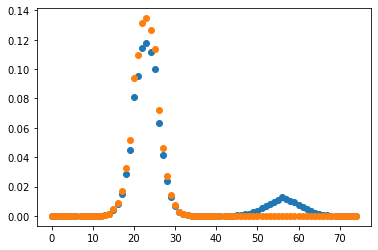

In [194]:
plt.scatter(range(len(B[0])), B[0])
plt.scatter(range(len(B[1])), B[1])

In [206]:
window_size = 3500
test_wind = 1500

train_start_indicies = np.array([0, 1000, 2000, 3000, 4000])
test_start_indicies = np.array([4000, 0, 1000, 2000, 3000])

In [208]:
for i in range(len(train_start_indicies)):
    
    A, B, pi = train(train_start_indicies[i], window_size)
    

    a, b, c, d = test(A, B, pi, test_start_indicies[i], test_wind)

    print(train_start_indicies[i], 'New: ', round(a, 4), round(b, 4), 'Old: ', round(c, 4), round(d, 4))
    

0 New:  0.9867 0.9973 Old:  0.9867 0.9973
1000 New:  0.9887 0.998 Old:  0.9887 0.998
2000 New:  0.988 0.994 Old:  0.9887 0.9947
3000 New:  0.988 0.9967 Old:  0.9887 0.9967
4000 New:  0.9887 0.9973 Old:  0.9887 0.9973
